In [13]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [14]:
from FBSNNs import *
from CallOption import *

In [136]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 512  # number of trajectories (batch size)
N = 200  # number of time snapshots
D = 1 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 4 * [21] + [1]

Xi = np.array([1.0] * D)[None, :]
T = 1.0

"Available architectures"
mode = "NAIS-Net"  # FC, Resnet and NAIS-Net are available
activation = "Sine"  # Sine and ReLU are available
model = CallOption(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2 * 10 ** 4
lr = 1e-3

In [62]:
n_iter = 11 * 10 ** 2
lr = 1e-7

In [63]:
tot = time.time()
print(model.device)
graph = model.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
It: 21900, Loss: 3.026e-04, Y0: 0.183, Time: 0.16, Learning Rate: 1.000e-07
It: 22000, Loss: 1.365e-02, Y0: 0.183, Time: 16.04, Learning Rate: 1.000e-07
It: 22100, Loss: 1.271e-03, Y0: 0.183, Time: 16.40, Learning Rate: 1.000e-07
It: 22200, Loss: 1.732e-03, Y0: 0.183, Time: 16.40, Learning Rate: 1.000e-07
It: 22300, Loss: 4.691e-04, Y0: 0.183, Time: 16.55, Learning Rate: 1.000e-07
It: 22400, Loss: 3.180e-04, Y0: 0.183, Time: 16.17, Learning Rate: 1.000e-07
It: 22500, Loss: 1.668e-04, Y0: 0.183, Time: 16.45, Learning Rate: 1.000e-07
It: 22600, Loss: 1.305e-03, Y0: 0.183, Time: 16.22, Learning Rate: 1.000e-07
It: 22700, Loss: 2.269e-04, Y0: 0.183, Time: 16.19, Learning Rate: 1.000e-07
It: 22800, Loss: 4.731e-04, Y0: 0.183, Time: 16.09, Learning Rate: 1.000e-07
It: 22900, Loss: 2.102e-03, Y0: 0.183, Time: 16.13, Learning Rate: 1.000e-07
total time: 179.10069966316223 s


In [137]:
model.load_model("models/CallOption3.pth")

In [230]:
np.random.seed(0)
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

for i in range(15):
    t_test_i, W_test_i = model.fetch_minibatch()
    X_pred_i, Y_pred_i = model.predict(Xi, t_test_i, W_test_i)
    if type(X_pred_i).__module__ != 'numpy':
        X_pred_i = X_pred_i.cpu().detach().numpy()
    if type(Y_pred_i).__module__ != 'numpy':
        Y_pred_i = Y_pred_i.cpu().detach().numpy()
    if type(t_test_i).__module__ != 'numpy':
        t_test_i = t_test_i.cpu().numpy()
    t_test = np.concatenate((t_test, t_test_i), axis=0)
    X_pred = np.concatenate((X_pred, X_pred_i), axis=0)
    Y_pred = np.concatenate((Y_pred, Y_pred_i), axis=0)


In [231]:
X_pred = X_pred[:500,:]

In [232]:
from scipy.stats import multivariate_normal as normal

In [233]:
X_preds1 = X_pred[:,:,0]

In [120]:
X_preds2 = X_pred[:,:,1]

IndexError: index 1 is out of bounds for axis 2 with size 1

In [236]:
def black_scholes_call(S, K, T, r, sigma, q=0):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * np.exp(-q * T) * normal.cdf(d1)) - (K * np.exp(-r * T) * normal.cdf(d2))
    return call_price

def calculate_option_prices(X_pred, time_array, K, r, sigma, T, q=0):
    rows, cols = X_pred.shape
    option_prices = np.zeros((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            S = X_pred[i, j]
            t = time_array[j]
            time_to_maturity = T - t
            if time_to_maturity > 0: 
                option_prices[i, j] = black_scholes_call(S, K, time_to_maturity, r, sigma, q)
            else:
                option_prices[i, j] = max(S - K, 0) 
    
    return option_prices


# Given parameters
K = 1.0     # Strike price
r = 0.05   # Risk-free interest rate
sigma = 0.4  # Volatility
q = 0      # Dividend yield (assuming none)
T = 1      # Expiry time in years

Y_test1 = calculate_option_prices(X_preds1, t_test[0], K, r, sigma, T, q)
# Y_test2 = calculate_option_prices(X_preds2, t_test[0], K, r, sigma, T, q)
Y_test = Y_test1 # + Y_test2

/tmp/ipykernel_1268574/3670736120.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  option_prices[i, j] = black_scholes_call(S, K, time_to_maturity, r, sigma, q)


In [237]:
errors = (Y_test[:500] - Y_pred[:500,:,0])**2
errors.mean(), errors.std()

(8.60943616262655e-05, 0.00012220510399571456)

In [238]:
np.sqrt(errors.mean())

0.009278704738607944

In [239]:
graph = model.iteration, model.training_loss

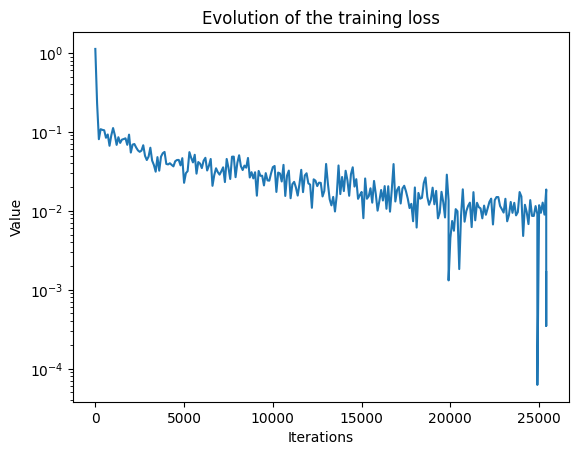

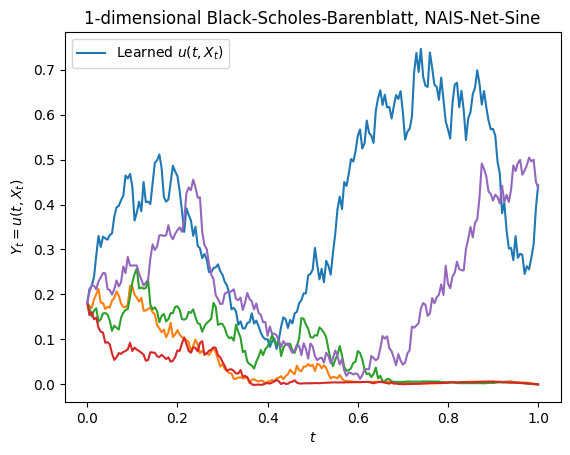

In [240]:
plt.figure()
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')
samples = 5
plt.figure()
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, label='Learned $u(t,X_t)$')

plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T)

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()

plt.show()

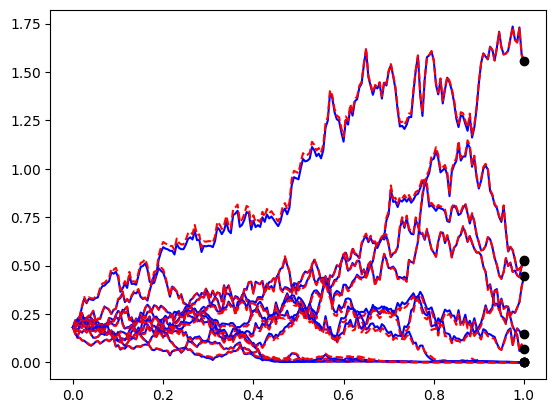

In [241]:
for i in range(0, 100, 10):
    plt.plot(t_test[i], Y_pred[i], 'b', label='Learned $u(t,X_t)$')
    plt.plot(t_test[i], Y_test[i], 'r--', label='Exact $u(t,X_t)$')
    plt.plot(t_test[i, -1], Y_test[i, -1], 'ko', label='$Y_T = u(T,X_T)$')

In [242]:
Y_pred.shape

(8192, 201, 1)

In [243]:
r = 0.05

In [244]:
Y_preds = Y_pred.reshape(8192,201)

In [245]:
time_stamps = t_test[0].reshape(201,)
time_stamps

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535,
       0.54 , 0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 ,
       0.585, 0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625,
       0.63 , 0.635,

In [246]:
epe = np.mean(np.exp(-r*time_stamps) * np.maximum(Y_preds,0),axis=0) * 100  
epe

array([18.099606, 18.08047 , 18.059536, 18.06803 , 18.046825, 18.03683 ,
       18.038311, 18.02506 , 18.030308, 18.019182, 18.013771, 18.04455 ,
       18.062246, 18.056381, 18.06437 , 18.05079 , 18.035952, 18.068443,
       18.063143, 18.04869 , 18.075775, 18.024822, 18.059906, 18.041676,
       18.039217, 18.04885 , 18.01205 , 17.994164, 18.038876, 18.02942 ,
       18.039707, 18.053495, 18.048883, 18.04235 , 18.04323 , 18.04492 ,
       18.089039, 18.102682, 18.103376, 18.12144 , 18.145113, 18.16863 ,
       18.196703, 18.213322, 18.202969, 18.198597, 18.19403 , 18.196033,
       18.177803, 18.215466, 18.252663, 18.242216, 18.27797 , 18.280582,
       18.290203, 18.291246, 18.323275, 18.325619, 18.291111, 18.328453,
       18.329365, 18.349718, 18.363379, 18.374077, 18.377178, 18.387058,
       18.359535, 18.357635, 18.366333, 18.40916 , 18.45376 , 18.418093,
       18.410343, 18.395863, 18.406885, 18.417381, 18.39901 , 18.387766,
       18.40264 , 18.392523, 18.43593 , 18.456047, 

In [247]:
ene = np.mean(np.minimum(Y_preds,0),axis=0) * 100
ene

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -4.72960892e-05,
       -1.03415819e-04, -1.98329872e-04, -3.51295341e-04, -4.38760064e-04,
       -3.88240733e-04, -4.01476049e-04, -4.72750427e-04, -5.85594447e-04,
       -8.51298857e-04, -9.65908112e-04, -1.11846032e-03, -1.19555602e-03,
       -1.34611980e-03, -1.43104268e-03, -1.33929739e-03, -1.55338657e-03,
       -1.70349178e-03, -1.98576320e-03, -2.13329960e-03, -2.36073253e-03,
       -2.87763984e-03, -3.02639743e-03, -3.20848590e-03, -3.65976337e-03,
       -3.88612435e-03, -3.95152206e-03, -4.58356366e-03, -4.97791311e-03,
       -5.12181502e-03, -5.32080606e-03, -5.67193422e-03, -6.00269763e-03,
       -6.35547610e-03, -

In [248]:
s=100.0 # spot price
k=100.0 # strike price
r=0.05 # risk-free rate
sigma=0.4 # volatility
T=1 # time to maturity

d1 = (np.log(s/k) + (r + 0.5 * sigma ** 2) * (T - 0) ) / (sigma * np.sqrt(T - 0))
d2 = (np.log(s/k) + (r - 0.5 * sigma ** 2) * (T - 0) ) / (sigma * np.sqrt(T - 0))

call = (s * normal.cdf(d1, 0.0, 1.0) - k * np.exp(-r * (T - 0) ) * normal.cdf(d2, 0.0, 1.0))

In [249]:
call

18.022951450216674

In [250]:
epe_exact = np.array([call for s in time_stamps[1:]])
ene_exact = np.array([0.0 for s in time_stamps[1:]])

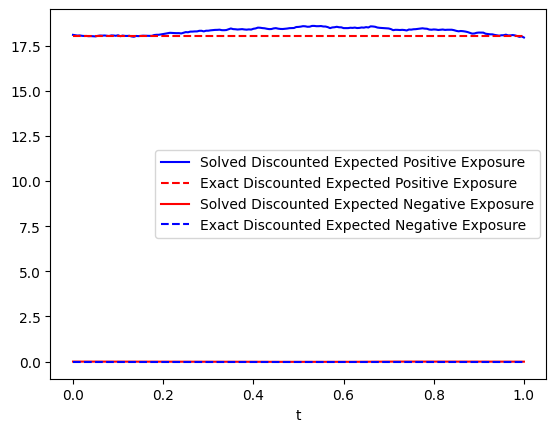

In [251]:
fig = plt.figure()
plt.plot(time_stamps,np.transpose(epe),'b',label='Solved Discounted Expected Positive Exposure' )
plt.plot(time_stamps,[call] + list(epe_exact),'r--',label='Exact Discounted Expected Positive Exposure')
plt.plot(time_stamps,np.transpose(ene),'r',label='Solved Discounted Expected Negative Exposure')
plt.plot(time_stamps,[0.0]+list(ene_exact),'b--',label='Exact Discounted Expected Negative Exposure')

plt.xlabel('t')
plt.legend()

plt.show()

In [66]:
model.save_model("models/CallOption5.pth")